<a href="https://colab.research.google.com/github/jhmartel/fp/blob/master/_notebooks/2022-11-02-WeberTwoBody_November_Corrected.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Integrating Newton-Weber Equations for Two Body Electrical Systems. 

> "We continue to investigate Weber's force law, especially in the two body isolated system. In this post we record the current status of our python code for integrating the Newton-Weber equations of motion. We model the orbits of the stable (-1)+(-1) molecule."

- toc: false
- branch: master
- badges: true
- comments: true
- author: JHM
- categories: [Weber, Newton, Two Body, critical radius]

# _Newton-Weber Equations in Isolated Two-Body Systems and the Critical Radius:_

We have not posted to JHM Labs blog in a week, and have been continuing our work with Weber's force, and specifically the two-body system $(-1) + (-1)$. Our interest in Weber's force law applied to two-body systems of identically charged particles is to numerically verify Weber and Assis' claim that two identical particles possess a _critical radius_ where the otherwise repulsive force becomes _attractive_! This is such a _key_ element of Weber's force law that we _must_ make it absolutely clear. In other words it's possible for two identical negatively charged particles to become a stable molecule of net charge $-2=-1-1$. This distance is the critical radius. Thus like charges repel outside the critical radius as expected by the dominant Coulomb interaction force. But given enough energy these same particles can pass through the critical radius and become a stable "molecule" in Weber's terminology. This is amazing prediction, and has been the primary focus of our investigations into these Newton-Weber equations. 

For an isolated two-body system of identically charged particles, the correct formula for the critical radius $r_c$ is not that given by Assis in his lectures [here](https://youtu.be/tpLQkZlA6Q8?t=1432). The error in Assis' derivation is that the acceleration terms $a_1$ and $a_2$ are actually _dependant_ in an isolated system, having to satisfy $$m_1 a_1 + m_2 a_2 = 0.$$ This means the coefficient on $a_1$ in the Newton-Weber equations is _not_ $$m_1 - \frac{q_i q_j}{c^2~r_{ij}}$$ but actually $$ m_1 - \frac{q_i q_j}{c^2~r_{ij}} \left( 1+ \frac{m_1}{m_2}\right).$$ When we have $q_i q_j=1.0$ and $m_1 = m_2 =1.0$ and $c^2 = 1.0$, this implies the formula for the critical radius is $$r_c =2.0$$ and _not_ equal to $1.0$ as the first formula would suggest. This caused us some confusion in our earlier reports [here], [here], [here]. 


# _Integrating Newton-Weber with Python's solve ivp:_

Initially we were studying implicit ODEs and this required using a DAE solver like GEKKO. However we have successfully isolated all the relevant acceleration terms and have made the Newton-Weber _explicit_. This means we can either integrate the equations through solve_ivp or we can more directly integrate the equations using kick-drift-kick approximations as we learned from [here](https://medium.com/swlh/create-your-own-n-body-simulation-with-python-f417234885e9). 

We do both.

In [ ]:
# collapse

# import the packages
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt

# speed of light constant, set to unity for convenience
c=1.0

# norm of vector x .... scalar
# softened norm with epsilon factor
def norm(x, epsilon=0.0):
  val = np.dot(x,x)**(0.5)
  return (val**2+epsilon**2)**(0.5)  ## epsilon softened parameter. This definition is discontinuous?

# relative distance r01 between x0, x1 .... scalar
def rho(x0,x1):
  r=np.subtract(x0,x1)
  return norm(r)

# returns ((N,3)) array of vectors. 
# Represents Weber force with only position and velocity terms
def F(state, epsilon=0.0):
  #c=1.0
  x, k = state
  N=len(x)
  aux = np.zeros((N,3))
  aux = np.array(aux, dtype=float)
  for i in range(N):
    for j in range(N):
      if i==j:
        pass
      else:
        r=np.subtract(x[j][0:3], x[i][0:3])  # r_ij, vector.
        rhat=np.dot(1/norm(r), r) # rhat, unit vector.
        Coulomb_factor = (-1)*k[i][-1]*k[j][-1]*(norm(r, epsilon)**-2)*(c**-2) # epsilon hard ball Coulomb factor.
        dv = np.subtract(x[j][3:6], x[i][3:6]) # dv= v_{ij}, vector.
        r_prime=np.dot(rhat, dv) # r' = rhat \cdot dv, scalar.
        s0 = c**2-(3/2)*(r_prime**2)+(norm(dv))**2  # scalar 
        aux[i] = aux[i]+np.dot(Coulomb_factor*s0, rhat) # vector
  return aux.reshape(-1) # flatten?

# auxiliary function, returns ((N,3)) array of vectors 
# depending on positions, velocity, and accelerations of the system
def P(state,a):
  x, k = state
  N=len(x)
  out = np.zeros((N,3))
  out = np.array(out, dtype=object)
  for i in range(N):
    for j in range(N):
      if i==j:
        pass
      else:
        r=np.subtract(x[j][0:3], x[i][0:3])  # r_ij, vector.
        rhat=np.dot(1/norm(r), r) # rhat, unit vector.
        Coulomb_factor = (+1)*k[i][-1]*k[j][-1]*(norm(r)**-1)*(c**-2) # scalar, not exactly Coulomb
        rhat_rescaled=np.dot(Coulomb_factor, rhat)   
        out[i] = out[i]+np.dot(np.dot(a[i], rhat), rhat_rescaled)
  return out 


# Q(state, a)[i] returns the component of acceleration due to the environment particles on m_i a_i. 
def Q(state,a):
  x, k = state
  N=len(x)
  out = np.zeros((N,3))
  out = np.array(out, dtype=object)
  for i in range(N):
    for j in range(N):
      if i==j:
        pass
      else:
        r=np.subtract(x[j][0:3], x[i][0:3])  # r_ij, vector.
        rhat=np.dot(1/norm(r), r) # rhat, unit vector.
        Coulomb_factor = (+1)*k[i][-1]*k[j][-1]*(norm(r)**-1)*(c**-2) # degree -1 Coulomb factor.
        rhat_rescaled=np.dot(Coulomb_factor, rhat)   
        out[i] = out[i]+np.dot(np.dot(a[j], rhat), rhat_rescaled)
  return out 

# G(state, a) evaluates the acceleration coefficients in Newton-Weber equation.
def G(state, a):
  x,k = state  
  N = len(x)
  M = [np.dot(k[i][0], a[i]) for i in range(N)]

  return list(((M - P(state, a) + Q(state, a)).reshape(-1)))

# G_m(state) returns matrix of coefficients, obtained by evaluating G(state, b) over a basis of 3N vectors in R^(3N)
def G_m(state):
  x,k = state
  N = len(x)
  aux = []
  for i in range(3*N):
    arg = np.identity(3*N)[i].reshape(N,3)
    row = G(state, arg)
    aux.append(row)
  return aux

# G_inv(state) returns the matrix inverse of G_m(state)
def G_inv(state):
  return np.linalg.inv(G_m(state))

# Key function: allows us to represent the accelerations terms explicitly in terms of the state input.
def H(state, epsilon=0.0):
  x,k = state
  N=len(x)
  return np.dot( G_inv(state), F(state, epsilon)).reshape((N, 3))
# left or right multiplication?? It makes a difference!

# Describes state in centre-of-mass reference frame.
def cm_frame(state):
  x, k = state
  N=len(x) # N-body system
  N1=len(x[0]) # number of coordinates, expect N1 == 9. 
  output = np.zeros((N,N1))
  output = np.array(output, dtype=float)
  M=0
  for i in range(N):
    M = M + k[i][0]
  for i in range(N):
    for j in range(N):
      if i==j:
        pass
      else:
        dr = np.subtract(x[i], x[j])
        output[i] = output[i] + np.dot((1/M)*k[j][0], dr)
  
  return output, k


# Weber Potential Energy. 
def U(x):
  x1,x2 = x
  dx = np.subtract(x2,x1)
  rhat=np.dot(1/norm(dx[0:3]), dx[0:3])  # unit vector
  Weber_term = (np.dot(rhat, dx[3:6]) / c)**2
  rho = norm(dx[0:3])
  return (rho**-1)*(1-Weber_term/2)


# Relative kinetic energy; pecialized to two body states!
def T(x, k):
  factor1 = k[0][0]*k[1][0]/(k[0][0]+k[1][0])
  x1,x2 = x
  dx = np.subtract(x2,x1)
  rhat=np.dot(1/norm(dx[0:3]), dx[0:3])
  factor2 = np.dot(rhat, dx[3:6])**2
  return factor1*factor2/2

# Transition matrix describing the explicit ODE. 
def Phi(t, state_flat, arg_input):
  k, epsilon = arg_input
  N = int(len(state_flat)//6) ## we know this is going to be integral.
  state_arg = [state_flat.reshape((N,6)), k]
  aux = []
  for j in range(N):
    aux = np.append(aux, state_flat[3+6*j:6+6*j]); 
    aux = np.append(aux,  H(state_arg, epsilon)[j]); 
  return np.dot(1.e-0, aux) 


The initial state is: 
 (array([[ 0.55 ,  0.   ,  0.   ,  0.   ,  0.025,  0.   ],
       [-0.55 ,  0.   ,  0.   ,  0.   , -0.025,  0.   ]]), [[1.0, -1.0], [1.0, -1.0]])
The initial total energy U+T is equal to:  0.9090909090909091
The total energy U+T along the solution, : [0.90909091 0.90869251 0.90055835 0.90519135 0.9088526  0.90907976
 0.90844495 0.88047108 0.90696577 0.90895838 0.90904684 0.9080492
 0.06693858 0.90782901 0.90902694 0.90898846 0.90736876 0.84741031
 0.90831125 0.90906762 0.90889715 0.90605585 0.89642199 0.9086049
 0.90908534 0.90875934 0.90299073 0.90394297 0.90879353 0.90908225
 0.90855047 0.89269012 0.90642974 0.90891793 0.90905815 0.90822328
 0.79566304 0.90755034 0.90899964 0.90901043 0.90767876 0.69127176
 0.90814804 0.90905036 0.90893313 0.90668069 0.88852305 0.9085016
 0.90907662 0.90881562 0.90454536 0.90205765 0.9087248  0.90908156
 0.90863853 0.89852811 0.90570423 0.90887101 0.9090659  0.9083656 ]


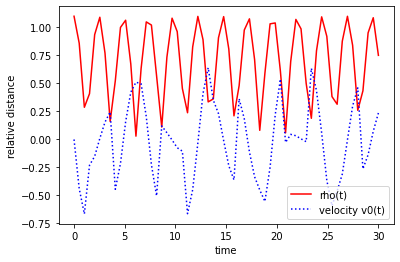

In [ ]:
# collapse

# relative errors and absolute errors.
relerr = 1.e-10
abserr = 1.e-10

# input state.
s0 = [[[1.1,0,0, 0,0.05,0], [0,0,0, 0,0,0]], [[1.0, -1.0], [1.0, -1.0]]]; s0 = cm_frame(s0);

print("The initial state is: \n", s0)

# time points.
t_points = np.linspace(0, 30, 60)

# Run ODE solver. 
sol = solve_ivp(Phi, t_span = [0, 30], y0 = s0[0].reshape(-1), t_eval = t_points, dense_output = False, rtol=relerr, atol=abserr, args = [[s0[1], 0.001]])

N= len(sol.y[0])

print("The initial total energy U+T is equal to: ", U(s0[0])+ T(s0[0], s0[1]))

# The following for loop checks the total energy U+T along the orbit.
aux = []
for j in range(N):
  x0 = [[sol.y[i][j] for i in range(6)], [sol.y[i+6][j] for i in range(6)]  ]
  aux = np.append(aux,[[U(x0) + T(x0, s0[1])]] )
print("The total energy U+T along the solution, :", aux)

N1=len(sol.y[0])

# Plotting the relative distance r=r(t) of an isolated two-body system.

r_list = [norm([sol.y[6][j]-sol.y[0][j], sol.y[7][j]-sol.y[1][j], sol.y[8][j]-sol.y[2][j]]) for j in range(N1)]

#print("r :", r_list)

plt.plot(t_points[0:N1], r_list, 'r-', label='rho(t)')
plt.plot(t_points[0:N1], sol.y[3], 'b:', label='velocity v0(t)')
plt.ylabel('relative distance')
plt.xlabel('time')
plt.legend(loc='best')
plt.show()


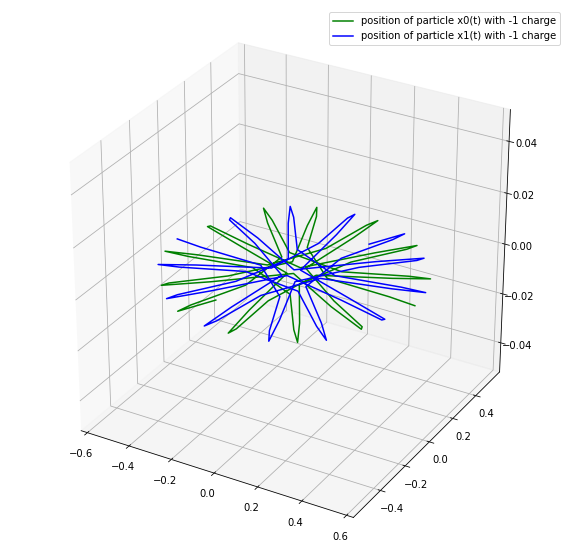

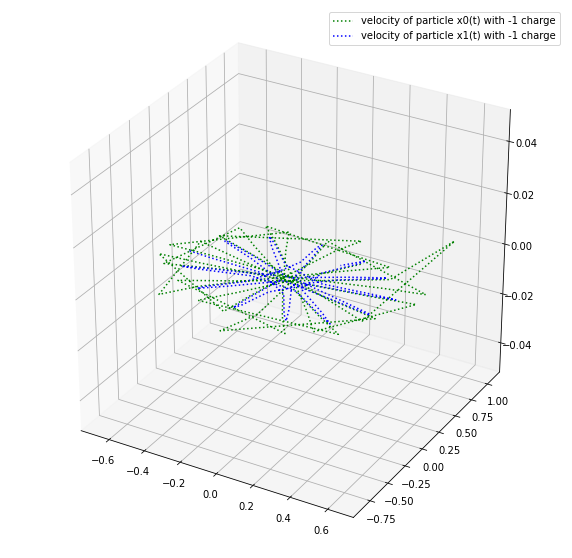

In [ ]:
# collapse

# We make 3D plot of the position of particles x0(t) and x1(t)
# also include 3D plot of the velocities of v0(t) of the particle x0. 

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
plt.plot(sol.y[0], sol.y[1], sol.y[2], "g", label='position of particle x0(t) with -1 charge')
plt.plot(sol.y[6], sol.y[7], sol.y[8], "b-", label='position of particle x1(t) with -1 charge')
#plt.quiver(sol.y[0], sol.y[1], sol.y[2], sol.y[3], sol.y[4], sol.y[5], color = 'r', label='x0(t) with -1 charge')
#plt.quiver(sol.y[6], sol.y[7], sol.y[8], sol.y[9], sol.y[10], sol.y[11], color = 'g', label='x1(t) with -1 charge')
plt.legend(loc='best')
plt.show()

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
plt.plot(sol.y[3], sol.y[4], sol.y[5], "g:", label='velocity of particle x0(t) with -1 charge')
plt.plot(sol.y[6], sol.y[7], sol.y[8], "b:", label='velocity of particle x1(t) with -1 charge')
#plt.quiver(sol.y[0], sol.y[1], sol.y[2], sol.y[3], sol.y[4], sol.y[5], color = 'r', label='x0(t) with -1 charge')
#plt.quiver(sol.y[6], sol.y[7], sol.y[8], sol.y[9], sol.y[10], sol.y[11], color = 'g', label='x1(t) with -1 charge')
plt.legend(loc='best')
plt.show()


# _Integrating Newton-Weber Following NMoscz' Vectorized Kick-Drift-Kick Pattern:_

__Reference__ : [Moscz' github repository](https://github.com/pmocz/nbody-python)  for nbody-python, which pattern we basically adapted. 



In [ ]:
# collapse

# initial input state vector.
s0 = [[[1.1,0.0,0, 0,0.05,0], [0,0,0, 0,0,0]], [[1.0, -1.0], [1.0, -1.0]]]; s0 = cm_frame(s0);

# Epsilon is "softening parameter"
epsilon=.1

# End time.
tEnd = 40.0

# Time step
dt = 0.001

# Number of time points.
Nt = int(np.ceil(tEnd/dt))

# All discrete time points in the interval of integration.
t_all = np.arange(Nt+1)

# Initialize time at t=0.
t=0

# Initializing the saved state vector. 
state_save = np.zeros((2, 6, Nt+1))

# Setting initial state argument.
state_arg = s0[0];
state_save[:, :, 0] = state_arg

# Run the main for loop, implement kick-drift-kick approximation.
for i in range(Nt):
  acc = H([state_arg, s0[1]], epsilon)
	# half kick, velocity update.
  state_arg[:, 3:6] += acc * dt/2.0
  # drift, position update.
  state_arg[:,0:3] += state_arg[:, 3:6] * dt
  #update acceleration, re-evaluate according to updated state_arg.
  acc = H([state_arg, s0[1]], epsilon)
  # half kick, velocity update.
  state_arg[:, 3:6] += acc * dt/2.0
  #update time
  t+=dt
  state_save[:,:,i+1] = state_arg

# Relabel the saved state.
y = state_save;


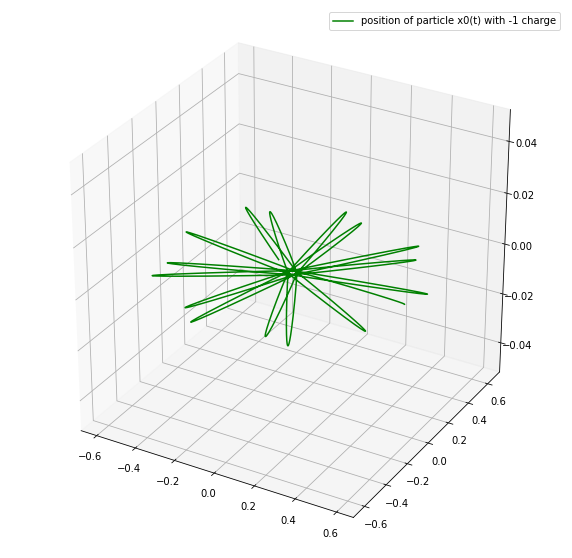

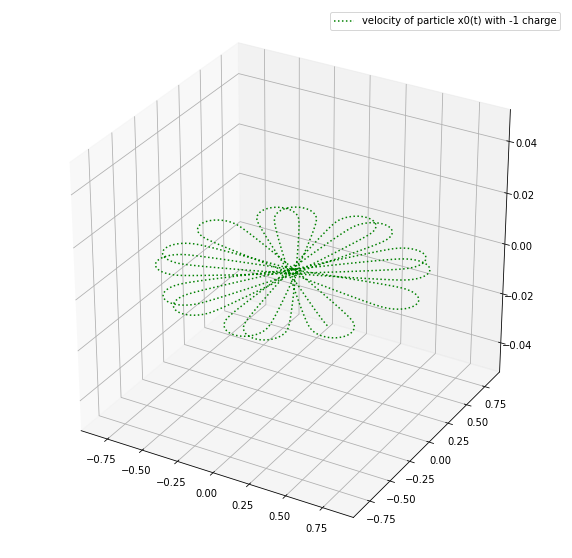

In [ ]:
# collapse

# prep figure

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
xs = y[0, 0, :]
ys = y[0, 1, :]
zs = y[0, 2, :]
plt.plot(xs, ys, zs, "g", label='position of particle x0(t) with -1 charge')
plt.legend(loc='best')
plt.show()

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
xs = y[0, 3, :]
ys = y[0, 4, :]
zs = y[0, 5, :]
plt.plot(xs, ys, zs, "g:", label='velocity of particle x0(t) with -1 charge')
plt.legend(loc='best')
plt.show()

# _Conclusion:_

The above images are pretty good. In fact we're very pleased with the vectorized implementation since the solution is definitely obtained quickly, and we find the 3D images are quite satisfactory. Having successfully verified the critical radius and the stable molecule consisting of identical negative electric charges $(-1) + (-1)$, we now proceed with the three-body problem!

-JHM.

# hide

In previous posts [insert] we discussed the use of GEKKO to solve the implicit ODEs arising from Newton's 2nd Law combined with Weber's force. However we have realized that the specific form of these Newton-Weber type equations allows us to convert these _implicit_ equations to _explicit_ equations. In other words, we _can_ isolate all the necessary acceleration terms and use a more conventional ODE solver, for example, scipy's solve_ivp. 

This was necessary because we found GEKKO useful for the implicit form, but it was not capable of performing the final matrix inversion required to make the system explicit. The problem is that matrix inversion using np.linalg.inv cannot handle GEKKO operators as input. This is similiar to np.linalg.inv being incapable of inverting arrays which contain symbols or indeterminates. So we will _not_ be using GEKKO for the remainder of our experiments, since we do not need it's DAE functionality. Instead we are happy to report that Newton-Weber equation _can_ be made explicit, this being the focus of our work for the last week.